# Predicción de precios de las propiedades

En este tercer proyecto, se seguirá trabajando con el dataset de propiedades en venta publicadas en el portal [Properati](www.properati.com.ar). El objetivo es armar un primer y sencillo modelo para predecir el precio de las propiedades en dólares.

Para empezar esta predicción se agregan las columnas:
* 'barrios_match': donde la coincidencia del barrio publicado con el barrio geográfico equivale a 1, si no equivale a 0.
* 'PH', 'apartment', 'house': variables binarias que indican el tipo de propiedad, creadas en el proyecto "Limpieza y transformación de datos.
* dummies de barrios: variables binarias con 1 o 0 según el barrio.

La métrica que se utiliza para medir es RMSE (raíz del error cuadrático medio), cuya fórmula es:

$$RMSE = \sqrt{\frac{\sum_{t=1}^n (\hat y_t - y_t)^2}{n}}$$

El objetivo principal de este proyecto es trabajar en el ajuste de modelos y su posterior evaluación.

In [20]:
import pandas as pd
import numpy as np
pd.set_option('display.float_format', lambda x: '%.3f' % x)
path_dataset = 'dataset/datos_properati_limpios_model.csv'
df = pd.read_csv(path_dataset)
df.shape

(6376, 59)

In [21]:
print("El dataset que vamos a trabajar aquí tiene {} observaciones".format(df.shape[0]))

El dataset que vamos a trabajar aquí tiene 6376 observaciones


Para empezar se divide el dataset en un conjunto de entrenamiento, para el cual será utilizado el 80% de los datos y un conjunto de testeo con el restante 20%.

In [22]:
X = df.drop(['price_aprox_usd'], axis=1)
y = df['price_aprox_usd']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [23]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(5100, 58)
(1276, 58)
(5100,)
(1276,)


<h2><center>Árboles de Decisión</center></h2>
El primer modelo que se entrenará es un árbol de decisión utilizando al RMSE (root mean square error) como métrica. Para poder obtener el RMSE se mide el MSE (mean_squared_error) y se obtiene su raíz cuadrada. 

Se importa el DecisionTreeRegressor desde la librería sklearn.tree y a continuación se entrena el regresor con el conjunto de training.

In [24]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor(criterion = 'mse', random_state=0)
tree_reg.fit(X_train, y_train)
print("The model training score is" , tree_reg.score(X_train, y_train))

The model training score is 0.9996379725515728


Con el modelo entrenado se realiza la predicción sobre el conjunto de test y se guarda el resultado en la variable creada 'y_pred'.

In [25]:
tree_reg_predict = tree_reg.predict(X_test)
y_pred = tree_reg_predict
print("The model test score is" , tree_reg.score(X_test, y_test))

The model test score is 0.37683102993492557


Se calcula el RMSE sacando la raíz cuadrada del mean_squared_error entre 'y_test' e 'y_pred' y se muestra el resultado a continuación:

In [26]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
rmse

25488.868711874235

### Profundidad del árbol de decisión
Se analiza el cambio en el RMSE a medida que es más profundo el árbol de decisión, tanto en training como en testing.

En este caso se decidió iterar de de 5 en 5 en el parámetro 'max_depth' y se observa como impacta en el RMSE. Los valores de cada profundidad son guardados en dos arreglos creados con este fin que son: 'rmses_train' y 'rmses_test' respectivamente.

In [27]:
rmses_train = []
rmses_test = []
max_depth_range = list(range(1, 30, 5))
for depth in max_depth_range:
    
    tree_reg = DecisionTreeRegressor( max_depth=depth, random_state=0)
    tree_reg.fit(X_train, y_train)    
    y_pred1 = tree_reg.predict(X_train)
    train_mse = mean_squared_error(y_train, y_pred1)
    rmses_train.append(np.sqrt(train_mse))
    y_pred = tree_reg.predict(X_test)
    test_mse = mean_squared_error(y_test, y_pred)
    rmses_test.append(np.sqrt(test_mse))      
    
print(rmses_train)
print(rmses_test)

[26609.89436754833, 20382.209795733415, 14635.979739737395, 7696.503784241797, 3243.62625035064, 1055.3203350402935]
[27117.012791354482, 21553.59811383829, 22212.77609998383, 24829.72457672366, 25964.02179852559, 25202.74893436961]


Visualizamos en un plot los valores guardados en los arreglos 'rmses_train' y 'rmses_test'.

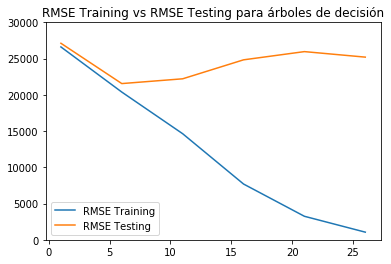

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline 
plt.plot(list(range(1,30, 5)), rmses_train, label='RMSE Training')
plt.plot(list(range(1,30, 5)), rmses_test, label='RMSE Testing')
plt.ylim((0, 30000))
plt.legend(loc="best")
plt.title("RMSE Training vs RMSE Testing para árboles de decisión")
plt.show()

Gracias a este gráfico podemos ver que el modelo presenta sobreajuste, que a mayor complejidad (mayor profundidad del árbol, en este caso) más diferencia entre los resultados de training y testing. También se observa como la curva de testing decrece y luego vuelvo a crecer. El punto donde se minimiza está relacionado con el tradeoff entre sesgo y varianza.

<h2><center>K-Nearest Neighbors</center></h2>
En este punto se entrena un modelo KNN y nuevamente se mide el RMSE en el conjunto de testing.

In [29]:
from sklearn.neighbors import KNeighborsRegressor
knn_reg = KNeighborsRegressor()
knn_reg.fit(X_train, y_train)
knn_reg_predict = tree_reg.predict(X_test)
y_pred = tree_reg_predict

In [30]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
rmse

25488.868711874235

Como en el caso anterior, se analiza el cambio en el RMSE a medida que son considerados más vecinos para KNN, tanto en training como en testing. Para esto, se itera incrementando de a uno el parámetro 'n_neighbors' y se observa el impacto en el RMSE. 

Se repite el proceso con los arreglos 'rmses_train' y 'rmses_test' para cada profundidad y se grafican.

In [31]:
rmses_train = []
rmses_test = []
n_neighbors_range = list(range(1, 30, 1))
for neighbors in n_neighbors_range:
    
    knn_reg = KNeighborsRegressor(n_neighbors= neighbors)
    knn_reg.fit(X_train, y_train)    
    y_pred1 = knn_reg.predict(X_train)
    train_mse = mean_squared_error(y_train, y_pred1)
    rmses_train.append(np.sqrt(train_mse))
    y_pred = knn_reg.predict(X_test)
    test_mse = mean_squared_error(y_test, y_pred)
    rmses_test.append(np.sqrt(test_mse))      
    
print(rmses_train)
print(rmses_test)

[808.7614367467254, 13541.384633338765, 16301.289430204964, 17820.620147941954, 18633.583124475565, 19329.766298113245, 19738.92842265714, 20102.95076556128, 20410.85009536354, 20612.138623933963, 20851.648741358757, 21015.095123233576, 21161.844784613288, 21305.152123136424, 21428.585266371287, 21543.451438699652, 21622.22688380982, 21736.27889718035, 21837.692245413047, 21911.129623496992, 21997.594927375743, 22077.105860819232, 22146.255192271245, 22213.87697128879, 22293.637891287235, 22355.455538408067, 22405.60239655632, 22458.29675463643, 22505.88588900403]
[27549.404244125337, 24763.46327559512, 23616.334094871785, 23400.83198140418, 23037.968959065478, 22845.55247681032, 22836.39264981179, 22842.449149028365, 22918.70050229542, 22912.973341314286, 22934.441591752955, 22990.874848037023, 23088.155465058913, 23099.929292230292, 23088.94331295892, 23091.944530037305, 23079.309513522938, 23119.921735862972, 23135.408439818424, 23165.091661596958, 23204.645879571024, 23222.42973319

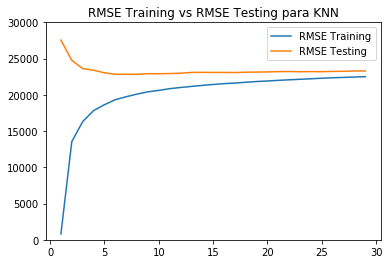

In [32]:
plt.plot(range(1,30, 1), rmses_train, label='RMSE Training')
plt.plot(range(1,30, 1), rmses_test, label='RMSE Testing')
plt.ylim((0, 30000))
plt.legend(loc="best")
plt.title("RMSE Training vs RMSE Testing para KNN")
plt.show()

Viendo este gráfico se puede concluir, que a diferencia del arbol de decisión, al aumentar los vecinos considerados en el modelo, la diferencia entre los resultados de training y testing es menor y por lo tanto mayor ajuste.

Por último se calcula el RMSE promedio resultante del cross validation para un árbol de decisión. 
Como parámetros se aplican: 
- 10 folds
- Profundidad 5
- Scoring neg_mean_squared_error

**Nota:** 'cross_validation_score' de Scikit-learn utiliza la métrica NMSE (neg_mean_squared_error) en lugar de MSE (mean_square_error), es decir MSE pero con signo negativo.

Para obtener el MSE, que es el que se necesita (en este caso), se calcula sobre él el RMSE, se define el método 'nmsq2rmse' para hacer la conversión de NMSE a MSE. El árbol de decisión es guardado en una variable llamada 'regressor'.

In [33]:
def nmsq2rmse(score):
    return np.sqrt(-score)

In [34]:
from sklearn.model_selection import cross_val_score
regressor = DecisionTreeRegressor(max_depth=5, random_state=0)
regressor.fit(X_train, y_train)
score = cross_val_score(regressor, X_train, y_train,
                             scoring="neg_mean_squared_error", cv=10)

rmses = np.sqrt(-score)
rmses.mean()

22104.89126628981

Para ver el resultado final, se reentrena el regresor y se muestra en un dataframe la comparación entre los valores reales, los predichos y su diferencia.

In [35]:
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
val_real = pd.Series(y_test.values)
val_pred = pd.Series(y_pred)

In [36]:
predicciones = pd.concat([val_real.rename('Valor real'),val_pred.rename('Valor Pred') ,abs(val_real-val_pred).rename('Dif(+/-)')] ,  axis=1)

In [37]:
predicciones.head(10)

,Valor real,Valor Pred,Dif(+/-)
0,76000.000,85303.622,9303.622
1,106000.000,147326.850,41326.850
2,150000.000,142555.341,7444.659
3,95000.000,100195.158,5195.158
4,67000.000,87812.382,20812.382
5,145000.000,137856.099,7143.901
6,114000.000,112377.354,1622.646
7,167300.000,143489.900,23810.100
8,98000.000,112377.354,14377.354
9,98000.000,128958.993,30958.993
